In [110]:
np.random.seed(5)

from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
from scipy import fftpack, interpolate, signal, stats
from sklearn import preprocessing

MOVIE_DURATION = 42 * 60  # 42 minutes
SAMPLING_FREQ = 100  # Hz

get_sampling_freq = lambda time: int(np.nanmean(1 / np.diff(time)))


def generate_firing_rate(
    is_tpc: bool = True,
    periodicity: Optional[np.ndarray] = np.array([200]),
    amplitude: np.ndarray = np.array([5]),
    sampling_freq: int = SAMPLING_FREQ,
    movie_duration: float = MOVIE_DURATION,
):
    """Function that generates synthetic firing rate of a given neuron, with or without periodicity (using either a sine function + jitter or a constant + jitter).

    Parameters
    ----------
    is_tpc : bool
        Whether the firing will have periodicity or not, by default True.

    periodicity : Optional[np.ndarray]
        Periodicity in firing in seconds, by default 200. For non-periodic units this can be left as `None`.

    amplitude : np.ndarray
        Amplitude associated with each periodicity.

    sampling_freq : int
        Sampling frequency in Hz.

     movie_duration: float
        The duration of the signal, here the duration of the episode in seconds.

    Returns
    -------
    fr : np.ndarray
        Firing rate of the neuron.

    time : np.ndarray
        The time vector associated with the firing rate.
    """
    time = np.arange(movie_duration, step=1 / sampling_freq)
    if is_tpc == True:
        fr = np.dot(
            amplitude[np.newaxis, :],
            np.cos(np.pi + 2 * np.pi * (1 / periodicity[:, np.newaxis]) * time),
        ).squeeze()
        fr -= np.min(fr)
    else:
        fr = np.sum(amplitude) * np.ones_like(time)

    # add jitter
    fr += np.random.rand(*fr.shape)

    return fr, time


def compute_autocorrelation(time: np.ndarray, x: np.ndarray):
    """This function calculates the autocorrelation of a time series

    Parameters
    ----------
    time : np.ndarray
        Time vector.

    x : np.ndarray
        Signal time series data

    Returns
    -------
    lags: np.array
        Autocorrelation lags (in seconds).

    autocorrelation: np.ndarray
        Array of autocorrelation values at each lag.
    """
    sampling_freq = get_sampling_freq(time)

    autocorrelation = signal.correlate(x, x, mode="full")
    lags = signal.correlation_lags(x.size, x.size, mode="full") / sampling_freq

    return lags, autocorrelation


def compute_fft(
    data: np.ndarray,
    sampling_freq: float,
):
    """This function calculates fft from a time series.

    Parameters
    ----------
    data : np.ndarray
        Time series of the signals for which FFT will be computed.

    sampling_freq : float
        Sampling frequency (Hz).

    Returns
    -------
    periods: np.array
        Array of periods

    amplitude: np.ndarray
        Amplitude of the signal at each period.

    """
    if data.ndim < 2:
        data = data[:, np.newaxis]
    num_samples = data.shape[0]
    fft = fftpack.fft(data, axis=0)
    freq = np.fft.fftfreq(num_samples, 1 / sampling_freq)
    amplitude = np.abs(fft)
    valid = (freq > 1e-3) & (freq < 1000)

    return 1 / freq[valid], amplitude[valid].squeeze()


def compute_dominant_periodicity(periods: np.ndarray, amplitude: np.ndarray):
    """This function gets the output of fft and computes the present periodicities in the firing.

    Parameters
    ----------
    periods : np.ndarray
        The period vector output by the fft function.

    amplitude : np.ndarray
        The amplitude vector.

    Returns
    -------
    periodicity: np.array
        Array of periodicities present in the signal.
    """
    x = periods
    y = amplitude
    # interpolate to make the periods uniform
    x_new = np.arange(periods.min(), periods.max(), step=1)
    f = interpolate.interp1d(x, y)
    y_new = f(x_new)

    y_new = signal.savgol_filter(y_new, 5,3)
    ind, _ = signal.find_peaks(y_new / y_new.max(), distance=10, height=.1)
    periodicity, peak_val = x_new[ind], y_new[ind]
    idx_sorted_peak = np.argsort(peak_val)[::-1]
    
    return periodicity[idx_sorted_peak]


def generate_shuffled_autocorr(
    time: np.ndarray, fr: np.ndarray, autocorr: np.ndarray, num_shuffles: int
):
    """This function shuffles the original firing rate and computes the autocorrelation of shuffled FRs.

     For the first half of the shuffles, data will be chunked into 1s-long epochs and for the second half 2-s long epochs.

    Parameters
    ----------
    time : np.ndarray
        Time vector associated with the firing rate.

    fr : np.ndarray
        The array of neuron's firing rate.

    autocorr : np.ndarray
        The array of autocorrelation of the original firing rate

    num_shuffles : int
        Number of shuffles to be performed.

    Returns
    -------
    shuffled_autocorr: np.ndarray
        The matrix of autocorrelations obtained from shuffled firing rates. Must be of the shape num_shuffles x num_lags
    """
    sampling_freq = get_sampling_freq(time)
    shuffled_autocorr = np.full((num_shuffles, len(autocorr)), np.nan)
    for idx_shuffle in range(num_shuffles):
        shuffled_fr = fr.copy()
        if idx_shuffle < num_shuffles / 2:
            shuffled_fr = np.reshape(shuffled_fr, (sampling_freq, -1))
        else:
            shuffled_fr = np.reshape(shuffled_fr, (2 * sampling_freq, -1))
        shuffled_fr = np.random.permutation(shuffled_fr).ravel()

        _, temp_autocorrelation = compute_autocorrelation(time, shuffled_fr)
        shuffled_autocorr[idx_shuffle, :] = temp_autocorrelation

    return shuffled_autocorr


def detect_tpc(
    lags: np.ndarray,
    autocorr: np.ndarray,
    shuffled_autocorr: np.ndarray,
    ci: list = [2.5, 97.5],
):
    """This function detects whether a cell is a TPC given its firing rate autocorrelation and shuffles.

    Parameters
    ----------
    lags : np.ndarray
        The array of autocorrelation lags

    autocorr : np.ndarray
        The array of true FR autocorrelations

    shuffled_autocorr : np.ndarray
        The matrix of autocorrelations obtained from shuffled firing rates. Must be of the shape num_shuffles x num_lags

    ci : list
        Confidence intervals to be used for the shuffled data. By default [2.5, 97.5]%.

    Returns
    -------
    fraction_outside_ci: float
        Fraction of lags that the true autocorrelation is outside the shuffled CIs.
    """
    above_upper = autocorr > np.percentile(shuffled_autocorr, ci[1], axis=0)
    below_lower = autocorr < np.percentile(shuffled_autocorr, ci[0], axis=0)
    valid_lags = (lags > 10) & (
        lags < lags.max() / 4
    )  # too large of a periodicity for the duration of the movie
    fraction_outside_ci = np.sum((above_upper | below_lower) & valid_lags) / np.sum(
        valid_lags
    )

    return fraction_outside_ci


def quantify_tpcs(
    time: np.ndarray,
    fr: np.ndarray,
    num_shuffles: int = 200,
    return_shuffles: bool = False,
):
    """This function detects whether a cell is a TPC given its firing rate autocorrelation and shuffles.

    Parameters
    ----------
    time : np.ndarray
        The time vector corresponding to the neuron's firing rate.

    fr : np.ndarray
        The array of firing rate.

    num_shuffles : int
        The matrix of autocorrelations obtained from shuffled firing rates. Must be of the shape num_shuffles x num_lags

    ci : list
        Confidence intervals to be used for the shuffled data. By default [2.5, 97.5]%.

    return_shuffles: bool
        If True, the shuffled autocorrelations will be returned. By default, False.

    Returns
    -------
    data_tpc: Dict
        A dictionary containing different characterizations of the neuron.
    """
    data_tpc = {}

    sampling_freq = get_sampling_freq(time)

    # compute original FR autocorrelation
    lags, autocorr = compute_autocorrelation(time, fr)
    data_tpc["lags"] = lags
    data_tpc["autocorr"] = autocorr
    # get shuffles
    shuffled_autocorr = generate_shuffled_autocorr(time, fr, autocorr, num_shuffles)
    if return_shuffles:
        data_tpc["shuffled_autocorr"] = shuffled_autocorr
    else:
        data_tpc["shuffled_autocorr"] = []

    # determine if tpc or not (different implementation for the paper in MATLAB)
    data_tpc["is_tpc"] = detect_tpc(lags, autocorr, shuffled_autocorr)

    # compute zscored autocorrelation
    zscored_autocorr = np.squeeze(
        (autocorr - np.nanmean(shuffled_autocorr, axis=0, keepdims=True))
        / np.nanstd(shuffled_autocorr, axis=0, keepdims=True)
    )
    data_tpc["zscored_autocorr"] = zscored_autocorr

    # compute fft on the zscored autocorrelations and get periodicities
    periods, amplitude = compute_fft(zscored_autocorr, sampling_freq)
    periodicity = compute_dominant_periodicity(periods, amplitude)
    data_tpc["periods"] = periods
    data_tpc["amplitude"] = amplitude
    data_tpc["periodicity"] = periodicity

    return data_tpc

# Generate synthetic data

In [111]:
neurons_dict = {
    0: {"is_tpc":True, "periodicity":np.array([50]), "amplitude":np.array([2])},
    1: {"is_tpc":True, "periodicity":np.array([60]), "amplitude":np.array([3])},
    2: {"is_tpc":False, "periodicity":None, "amplitude":np.array([1])},
    3: {"is_tpc":False, "periodicity":None, "amplitude":np.array([5])},
    4: {"is_tpc":True, "periodicity":np.array([100]), "amplitude":np.array([3])},
    5: {"is_tpc":True, "periodicity":np.array([50,200]), "amplitude":np.array([3,4])},
    6: {"is_tpc":False, "periodicity":None, "amplitude":np.array([3])},
    7: {"is_tpc":False, "periodicity":None, "amplitude":np.array([1,2])},
    8: {"is_tpc":True, "periodicity":np.array([250]), "amplitude":np.array([3])},
    9: {"is_tpc":True, "periodicity":np.array([100,400]), "amplitude":np.array([1,2])},
    10: {"is_tpc":False, "periodicity":None, "amplitude":np.array([2])},
    11: {"is_tpc":False, "periodicity":None, "amplitude":np.array([6])},
    }

all_data_tpc = []
all_zscored_autocorr = []
all_is_tpc = []
all_fft_amplitude = []
for idx_neuron, info_neurons in neurons_dict.items():
  print(idx_neuron)
  fr, time = generate_firing_rate(**info_neurons)
  data_tpc = quantify_tpcs(time, fr)

  all_data_tpc.append(data_tpc)
  all_zscored_autocorr.append(data_tpc["zscored_autocorr"][np.newaxis,:])
  all_is_tpc.append(data_tpc["is_tpc"])
  all_fft_amplitude.append(data_tpc["amplitude"][np.newaxis,:])


0
1
2
3
4
5
6
7
8
9
10
11


# Get percentage of TPC stats

Text(0, 0.5, 'Fraction of TPCs')

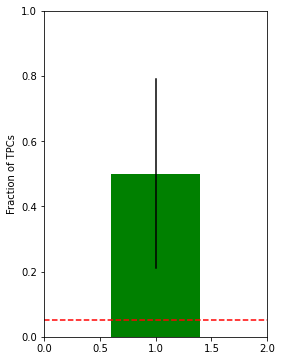

In [112]:
results = stats.binomtest(np.sum(np.array(all_is_tpc) > .5), n=len(all_is_tpc), p=0.5, alternative='two-sided')
plt.figure(figsize=(4,6))
plt.bar(1, results.proportion_estimate, color='g')
plt.plot([1,1], [results.proportion_ci().low, results.proportion_ci().high], color='k')
plt.axhline(.05, color='r', linestyle='--')
plt.xlim(0,2)
plt.ylim(0,1)
plt.ylabel('Fraction of TPCs')

# Plot Zscored autocorrelation for TPCs

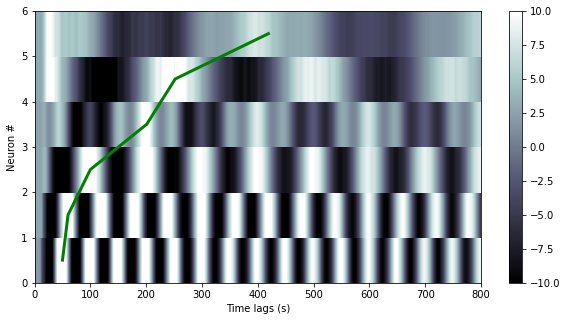

In [113]:
valid_tpc = np.where(np.array(all_is_tpc) > .5)[0]
valid_lags = (data_tpc["lags"] > 0) & (data_tpc["lags"] < 800)
tpc_autocorr = np.concatenate(all_zscored_autocorr, axis=0)

fig, ax = plt.subplots(figsize=(10,5))
p = ax.pcolor(data_tpc["lags"][valid_lags], np.arange(len(valid_tpc)+1), tpc_autocorr[valid_tpc][:, valid_lags], cmap="bone", vmin=-10, vmax=10)
ax.set_xlim(0, 800)
ax.set_xlabel("Time lags (s)")
ax.set_ylabel("Neuron #")
cb = fig.colorbar(p, ax=ax)

# get dominante periodicities
dominant_periodicity = np.array([x["periodicity"][0] for x in all_data_tpc])[valid_tpc]
ax.plot(dominant_periodicity, 0.5 + np.arange(len(valid_tpc)), color='g', linewidth=3)

# Plot FFT of zscored autocorr for TPCs (to inspect dominant and other periodicities)

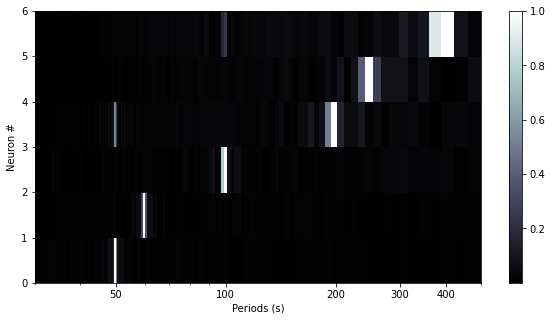

In [114]:
fft_amplitude = np.concatenate(all_fft_amplitude, axis=0)[valid_tpc]
fft_amplitude /= np.max(fft_amplitude, axis=1)[:, np.newaxis]
valid_periods = data_tpc["periods"]>10

fig, ax = plt.subplots(figsize=(10,5))
p = ax.pcolor(data_tpc["periods"][valid_periods], np.arange(len(valid_tpc)+1), fft_amplitude[:, valid_periods], cmap="bone")
ax.set_ylabel("Neuron #")
ax.set_xlim(30, 500)
ax.set_xlabel("Periods (s)")
ax.set_xscale('log')
ax.set_xticks([50, 100, 200, 300, 400])
ax.set_xticklabels([str(x) for x in [50, 100, 200, 300, 400]])
cb = fig.colorbar(p, ax=ax)

# note that for neurons number 3 and 5, two periodicities were specified which appear below as well
